In [24]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os.path

In [25]:
def conformal(g):
    c_1_prime = 1
    conf = - c_1_prime / 12 * (4 - np.pi * (1/g + 1/(np.pi - g) + 1/(np.pi + g) + 1/(2 * np.pi - g)))
    return conf

In [ ]:
class ShapeDep:
    def __init__(self, ls, n_max, type):
        self.ls = ls
        self.ns = range(n_max)
        self.type = type
        self.gammas = [ np.arctan2(1, n) for n in self.ns ]
        self.ln_ls = [ np.log(L/2) for L in self.ls ]
        self.inv_ls = [ 2/L for L in self.ls[:-1] ]
        self.lnl_ls = [ 2*np.log(L/2)/L for L in self.ls[:-1] ]
        self.scrs = []
        self.scr_batches = []
        self.scr_errs = []
        self.bs = []
        self.b_batches = []
        self.b_errs = []
        self.read_raw()
            
    def read_raw(self):
        scrs_batches = []
        for L in self.ls:
            scrs_batches_at_size = []
            scrs = []
            errs = []
            for n in self.ns:
                if (n > L//2):
                    break
                batches = [] # <- len = 10 list of avg. scr for each batch
                for i in range(10):
                    file = f'./results/{self.type}/{L}/scr-{L}-{n}-{i}.txt'
                    raw = pd.read_table(file, header=None, sep='/n', engine='python')
                    data = raw.to_numpy(na_value=0)
                    avg = np.sum(data, axis=None) / len(data)
                    batches.append(avg)
                scrs_batches_at_size.append(batches)
                scr = np.sum(batches, axis=None) / len(batches)
                err = np.std(batches) / np.sqrt(10)
                scrs.append(scr)
                errs.append(err)
            scrs_batches.append(scrs_batches_at_size)
            self.scrs.append(scrs)
            self.scr_errs.append(errs)
        self.scr_batches = scrs_batches
        for j in range(len(self.ls) - 1):
            d_ln_l = self.ln_ls[j+1] - self.ln_ls[j]
            bs = []
            errs = []
            batches_at_size = []
            for n in self.ns:
                if (n > self.ls[j] // 2):
                    break
                batches = []
                for i in range(10):
                    d_scr = scrs_batches[j+1][n][i] - scrs_batches[j][n][i]
                    batches.append( abs(d_scr / d_ln_l) )
                batches_at_size.append(batches)
                b = np.sum(batches, axis=None) / len(batches)
                err = np.std(batches) / np.sqrt(len(batches))
                bs.append(b)
                errs.append(err)
            self.b_batches.append(batches_at_size)
            self.bs.append(bs)
            self.b_errs.append(errs)

    def b_vs_gamma(self, size):
        return self.bs[self.ls.index(size)]

    def b_err_vs_gamma(self, size):
        return self.b_errs[self.ls.index(size)]
        
    def b_vs_invl(self, n):
        bs = []
        for i in range(len(self.ls) - 1):
            try:
                bs.append(self.bs[i][n])
            except IndexError:
                continue
        return bs

    def b_err_vs_invl(self, n):
        errs = []
        for i in range(len(self.ls) - 1):
            try:
                errs.append(self.b_errs[i][n])
            except IndexError:
                continue
        return errs

In [27]:
box = ShapeDep([8, 16, 32, 64, 128], 25, 'box')
fix = ShapeDep([8, 16, 32, 64, 128], 25, 'fixed')

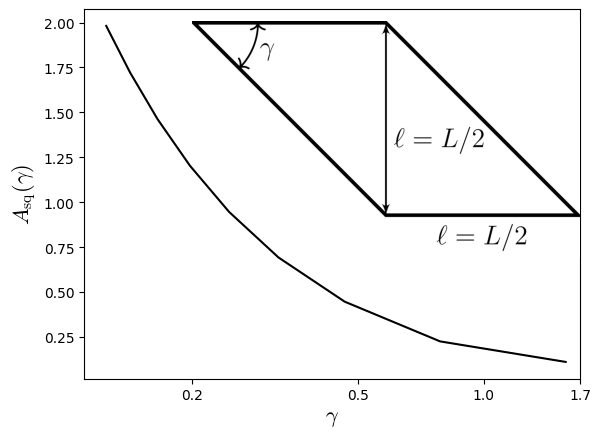

In [ ]:
import io
import fitz
from PIL import Image

file = 'shear-square-fig.pdf'
pdf_file = fitz.open(file)
page = pdf_file[0]
rgb = page.get_pixmap(dpi=1200)
pil_image = Image.open(io.BytesIO(rgb.tobytes()))

fig, ax = plt.subplots()
cp = [ conformal(g) for g in box.gammas[:9] ]


inset = ax.inset_axes([0.2, 0.6, 1.5, 1.5], transform=ax.transData)
inset.imshow(pil_image)
inset.set_axis_off()

ax.semilogx(box.gammas[:9], cp, 'k-', zorder=10)
ax.set_xlabel(f"$\\gamma$", fontsize=16, math_fontfamily='cm')
ax.set_ylabel(f"$A_{{\\rm sq}}(\\gamma)$", fontsize=16, math_fontfamily='cm')
ax.set_xlim([0.11,1.7])
ax.set_xticks([0.2, 0.5, 1, 1.7])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


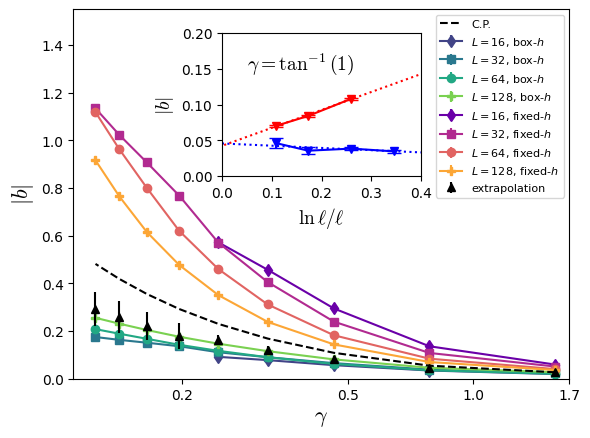

In [ ]:
fig, ax = plt.subplots()

boxcmap = plt.get_cmap('viridis')
fixcmap = plt.get_cmap('plasma')

b_ext = [0.027, 0.046, 0.083, 0.12, 0.162, 0.180, 0.221, 0.259, 0.293]
b_err = [0.006, 0.009, 0.014, 0.018, 0.021, 0.054, 0.06, 0.066, 0.072]
cp = [ conformal(g) * 0.243 for g in box.gammas[:9] ]

ax.errorbar(box.gammas[:5], box.b_vs_gamma(8), yerr=box.b_err_vs_gamma(8), fmt='-d', color=boxcmap(0.2), label=f'$L=16$, box-$h$')
ax.errorbar(box.gammas[:9], box.b_vs_gamma(16), yerr=box.b_err_vs_gamma(16), fmt='-s', color=boxcmap(0.4), label=f'$L=32$, box-$h$')
ax.errorbar(box.gammas[:9], box.b_vs_gamma(32)[:9], yerr=box.b_err_vs_gamma(32)[:9], fmt='-o', color=boxcmap(0.6), label=f'$L=64$, box-$h$')
ax.errorbar(box.gammas[:9], box.b_vs_gamma(64)[:9], yerr=box.b_err_vs_gamma(64)[:9], fmt='-P', color=boxcmap(0.8), label=f'$L=128$, box-$h$')
ax.errorbar(fix.gammas[:5], fix.b_vs_gamma(8), yerr=fix.b_err_vs_gamma(8), fmt='-d', color=fixcmap(0.2), label=f'$L=16$, fixed-$h$')
ax.errorbar(fix.gammas[:9], fix.b_vs_gamma(16), yerr=fix.b_err_vs_gamma(16), fmt='-s', color=fixcmap(0.4), label=f'$L=32$, fixed-$h$')
ax.errorbar(fix.gammas[:9], fix.b_vs_gamma(32)[:9], yerr=fix.b_err_vs_gamma(32)[:9], fmt='-o', color=fixcmap(0.6), label=f'$L=64$, fixed-$h$')
ax.errorbar(fix.gammas[:9], fix.b_vs_gamma(64)[:9], yerr=fix.b_err_vs_gamma(64)[:9], fmt='-P', color=fixcmap(0.8), label=f'$L=128$, fixed-$h$')
ax.errorbar(box.gammas[:9], b_ext, yerr=b_err, fmt='^', color='k', label='extrapolation', zorder=3)
ax.plot(box.gammas[:9], cp, 'k--', label='C.P.', zorder=3)
ax.set_xscale("log")
ax.set_xlabel(f"$\\gamma$", fontsize=16, math_fontfamily='cm')
ax.set_ylabel(f"$|b|$", fontsize=16, math_fontfamily='cm')
ax.set_ylim([0,1.55])
ax.legend(prop={'size': 8})
ax.set_xlim([0.11,1.7])
ax.set_xticks([0.2, 0.5, 1, 1.7])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 

inset = ax.inset_axes([0.25, 0.85, 0.5, 0.6], transform=ax.transData)
boxerr = box.b_err_vs_invl(1)
fixerr = fix.b_err_vs_invl(1)
inset.plot(box.lnl_ls, box.b_vs_invl(1), '-v', color='b', label='box disorder')
inset.plot(fix.lnl_ls[1:], fix.b_vs_invl(1)[1:], '-v', color='r', label='fixed disorder')
inset.errorbar(box.lnl_ls, box.b_vs_invl(1), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
inset.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(1)[1:], yerr=fixerr[1:], fmt='none', ecolor='r', capsize=5.0)
inset.set_xlabel(f"$\\ln \\ell/\\ell$", fontsize=14, math_fontfamily='cm')
inset.set_ylabel(f"$|b|$", fontsize=14, math_fontfamily='cm')
inset.set_ylim([0,0.2])
inset.set_xlim([0,0.4])

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(box.lnl_ls, box.b_vs_invl(1), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(1)[1:], 1, cov='unscaled', w=fix_weights[1:])
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
inset.plot(x, box_int + box_slope*x, 'b:')
inset.plot(x, fix_int + fix_slope*x, 'r:')
inset.text(0.05, 0.15, f"$\\gamma=\\tan^{{-1}}(1)$", fontsize=14, math_fontfamily='cm')

plt.show()

In [35]:
boxmulti = ShapeDep([8, 16, 32, 64, 128], 21, "box-multi")
fixmulti = ShapeDep([8, 16, 32, 64, 128], 21, "fixed-multi")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


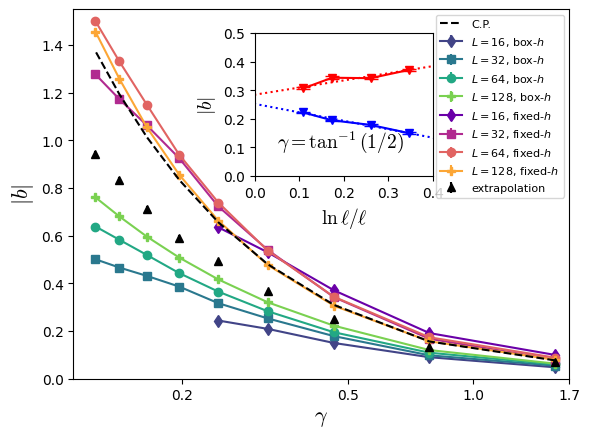

In [ ]:
fig, ax = plt.subplots()

boxcmap = plt.get_cmap('viridis')
fixcmap = plt.get_cmap('plasma')

b_ext = [0.071, 0.133, 0.252, 0.367, 0.494, 0.590, 0.711, 0.832, 0.942]
b_err = [0.002, 0.005, 0.005, 0.006, 0.007, 0.012, 0.012, 0.012, 0.012]

cp = [ conformal(g) * 0.693 for g in boxmulti.gammas[:9] ]

ax.errorbar(boxmulti.gammas[:5], boxmulti.b_vs_gamma(8), yerr=boxmulti.b_err_vs_gamma(8), fmt='-d', color=boxcmap(0.2), label=f'$L=16$, box-$h$')
ax.errorbar(boxmulti.gammas[:9], boxmulti.b_vs_gamma(16), yerr=boxmulti.b_err_vs_gamma(16), fmt='-s', color=boxcmap(0.4), label=f'$L=32$, box-$h$')
ax.errorbar(boxmulti.gammas[:9], boxmulti.b_vs_gamma(32)[:9], yerr=boxmulti.b_err_vs_gamma(32)[:9], fmt='-o', color=boxcmap(0.6), label=f'$L=64$, box-$h$')
ax.errorbar(boxmulti.gammas[:9], boxmulti.b_vs_gamma(64)[:9], yerr=boxmulti.b_err_vs_gamma(64)[:9], fmt='-P', color=boxcmap(0.8), label=f'$L=128$, box-$h$')
ax.errorbar(fixmulti.gammas[:5], fixmulti.b_vs_gamma(8), yerr=fixmulti.b_err_vs_gamma(8), fmt='-d', color=fixcmap(0.2), label=f'$L=16$, fixed-$h$')
ax.errorbar(fixmulti.gammas[:9], fixmulti.b_vs_gamma(16), yerr=fixmulti.b_err_vs_gamma(16), fmt='-s', color=fixcmap(0.4), label=f'$L=32$, fixed-$h$')
ax.errorbar(fixmulti.gammas[:9], fixmulti.b_vs_gamma(32)[:9], yerr=fixmulti.b_err_vs_gamma(32)[:9], fmt='-o', color=fixcmap(0.6), label=f'$L=64$, fixed-$h$')
ax.errorbar(fixmulti.gammas[:9], fixmulti.b_vs_gamma(64)[:9], yerr=fixmulti.b_err_vs_gamma(64)[:9], fmt='-P', color=fixcmap(0.8), label=f'$L=128$, fixed-$h$')
ax.errorbar(boxmulti.gammas[:9], b_ext, yerr=b_err, color='k', fmt='^', label='extrapolation', zorder=3)
ax.plot(boxmulti.gammas[:9], cp, 'k--', label='C.P.', zorder=3)
ax.set_xscale("log")
ax.set_xlabel(f"$\\gamma$", fontsize=16, math_fontfamily='cm')
ax.set_ylabel(f"$|b|$", fontsize=16, math_fontfamily='cm')
ax.set_ylim([0, 1.55])
ax.legend(prop={'size': 8})
ax.set_xlim([0.11,1.7])
ax.set_xticks([0.2, 0.5, 1, 1.7])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 

inset = ax.inset_axes([0.3, 0.85, 0.5, 0.6], transform=ax.transData)
boxerr = boxmulti.b_err_vs_invl(2)
fixerr = fixmulti.b_err_vs_invl(2)
inset.plot(fixmulti.lnl_ls, fixmulti.b_vs_invl(2), '-v', color='r', label='fixed disorder')
inset.plot(boxmulti.lnl_ls, boxmulti.b_vs_invl(2), '-v', color='b', label='box disorder')
inset.errorbar(boxmulti.lnl_ls, boxmulti.b_vs_invl(2), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
inset.errorbar(fixmulti.lnl_ls, fixmulti.b_vs_invl(2), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
inset.set_xlabel(f"$\\ln \\ell/\\ell$", fontsize=14, math_fontfamily='cm')
inset.set_ylabel(f"$|b|$", fontsize=14, math_fontfamily='cm')
inset.set_ylim([0,0.5])
inset.set_xlim([0,0.4])

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls, boxmulti.b_vs_invl(2), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls, fixmulti.b_vs_invl(2), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
inset.plot(x, box_int + box_slope*x, 'b:')
inset.plot(x, fix_int + fix_slope*x, 'r:')
inset.text(0.05, 0.1, f"$\\gamma=\\tan^{{-1}}(1/2)$", fontsize=14, math_fontfamily='cm')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


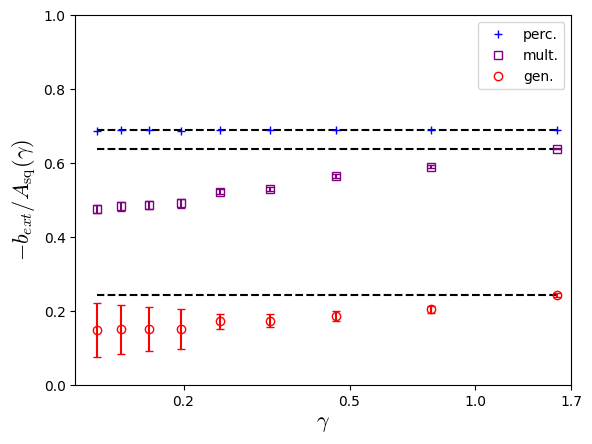

In [ ]:
b_ext = [0.027, 0.046, 0.083, 0.12, 0.162, 0.180, 0.221, 0.259, 0.293]
b_err = [0.006, 0.009, 0.014, 0.018, 0.021, 0.054, 0.06, 0.066, 0.072]
b_multi_ext = [0.071, 0.133, 0.252, 0.367, 0.494, 0.590, 0.711, 0.832, 0.942]
b_multi_err = [0.002, 0.005, 0.005, 0.006, 0.007, 0.012, 0.012, 0.012, 0.012]
gs = box.gammas[:9]
b_perc_ext = [0.998682011, 1.00045192, 1.000014332, 0.99912165, 0.999098149, 0.997199155, 1.000744033, 0.999760119, 0.997956701]

b_over_b = [ b_ext[i]/conformal(gs[i]) for i in range(9) ]
b_over_b_multi = [b_multi_ext[i]/conformal(gs[i]) for i in range(9)]
b_over_b_perc = [b_perc_ext[i] * 5*np.sqrt(3)/(4*np.pi) for i in range(9)]
analytic_percolation = [ 5*np.sqrt(3)/(4*np.pi) for i in range(9)]
qcp_square = [ 0.027/conformal(gs[0]) for i in range(9) ]
qcp_sq_err = 0.001
qmcp_square = [ 0.071/conformal(gs[0]) for i in range(9) ]
qmcp_sq_err = 0.0004

fig, ax = plt.subplots()

ax.plot(gs, b_over_b_perc, '+', color='b', mfc='none', label='perc.')
ax.plot(gs, b_over_b_multi, 's', color='purple', mfc='none', label='mult.')
ax.errorbar(gs, b_over_b_multi, yerr=b_multi_err, fmt='none', color='purple', capsize=3.0)
ax.plot(gs, b_over_b, 'o', color='r', mfc='none', label='gen.')
ax.errorbar(gs, b_over_b, yerr=b_err, fmt='none', color='r', capsize=3.0)
ax.plot(gs, analytic_percolation, '--k', zorder=0)
ax.plot(gs, qcp_square, '--k', zorder=0)
ax.plot(gs, qmcp_square, '--k', zorder=0)
ax.set_xscale('log')
ax.set_ylim([0, 1])
ax.set_xlabel(f'$\\gamma$', fontsize=16, math_fontfamily='cm')
ax.set_ylabel(f'$-b_{{ext}}/A_{{\\rm sq}}(\\gamma)$', fontsize=16, math_fontfamily='cm')
ax.set_xlim([0.11,1.7])
ax.set_xticks([0.2, 0.5, 1, 1.7])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.legend()
plt.show()

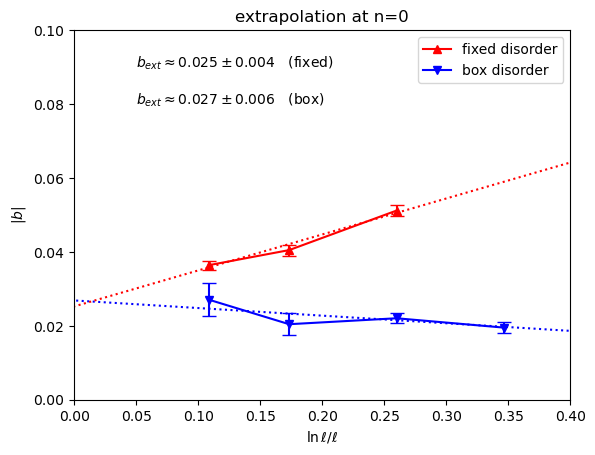

In [7]:
fig, ax = plt.subplots()
boxerr = box.b_err_vs_invl(0)
fixerr = fix.b_err_vs_invl(0)
ax.plot(fix.lnl_ls[1:], fix.b_vs_invl(0)[1:], '-^', color='r', label='fixed disorder')
ax.plot(box.lnl_ls, box.b_vs_invl(0), '-v', color='b', label='box disorder')
ax.errorbar(box.lnl_ls, box.b_vs_invl(0), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(0)[1:], yerr=fixerr[1:], fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.1])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=0')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(box.lnl_ls, box.b_vs_invl(0), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(0)[1:], 1, cov='unscaled', w=fix_weights[1:])
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.09, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.05, 0.08, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

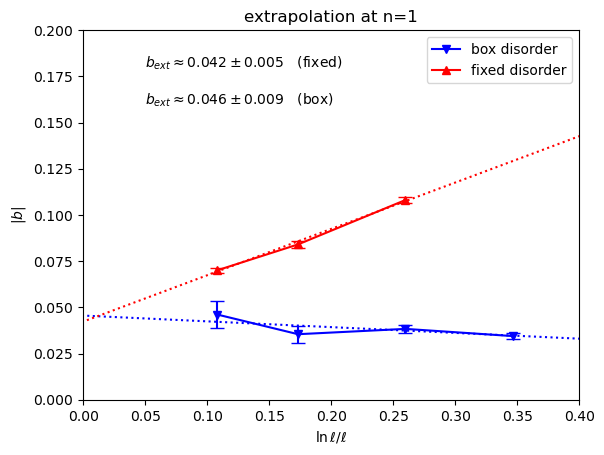

In [32]:
fig, ax = plt.subplots()
boxerr = box.b_err_vs_invl(1)
fixerr = fix.b_err_vs_invl(1)
ax.plot(box.lnl_ls, box.b_vs_invl(1), '-v', color='b', label='box disorder')
ax.plot(fix.lnl_ls[1:], fix.b_vs_invl(1)[1:], '-^', color='r', label='fixed disorder')
ax.errorbar(box.lnl_ls, box.b_vs_invl(1), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(1)[1:], yerr=fixerr[1:], fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.2])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=1')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(box.lnl_ls, box.b_vs_invl(1), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(1)[1:], 1, cov='unscaled', w=fix_weights[1:])
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.18, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.05, 0.16, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

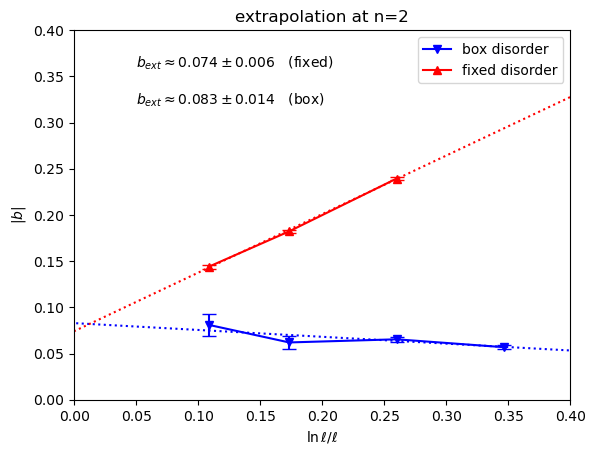

In [33]:
fig, ax = plt.subplots()
boxerr = box.b_err_vs_invl(2)
fixerr = fix.b_err_vs_invl(2)
box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
ax.plot(box.lnl_ls, box.b_vs_invl(2), '-v', color='b', label='box disorder')
ax.plot(fix.lnl_ls[1:], fix.b_vs_invl(2)[1:], '-^', color='r', label='fixed disorder')
ax.errorbar(box.lnl_ls, box.b_vs_invl(2), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(2)[1:], yerr=fixerr[1:], fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.4])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=2')

boxcoeff, boxcov = np.polyfit(box.lnl_ls, box.b_vs_invl(2), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(2)[1:], 1, cov='unscaled', w=fix_weights[1:])
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.36, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.05, 0.32, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

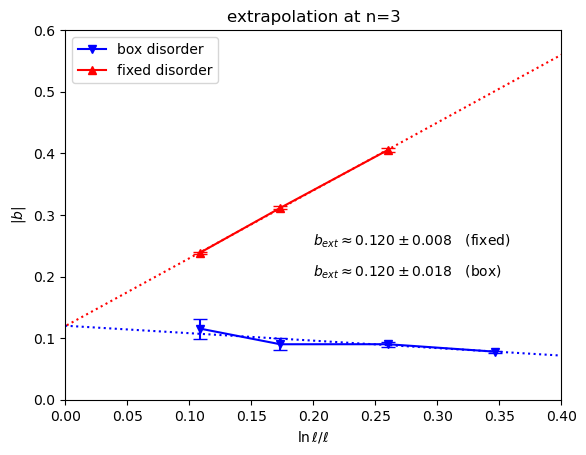

In [34]:
fig, ax = plt.subplots()
boxerr = box.b_err_vs_invl(3)
fixerr = fix.b_err_vs_invl(3)
box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
ax.plot(box.lnl_ls, box.b_vs_invl(3), '-v', color='b', label='box disorder')
ax.plot(fix.lnl_ls[1:], fix.b_vs_invl(3)[1:], '-^', color='r', label='fixed disorder')
ax.errorbar(box.lnl_ls, box.b_vs_invl(3), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(3)[1:], yerr=fixerr[1:], fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.6])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=3')

boxcoeff, boxcov = np.polyfit(box.lnl_ls, box.b_vs_invl(3), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(3)[1:], 1, cov='unscaled', w=fix_weights[1:])
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.2, 0.25, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.2, 0.2, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

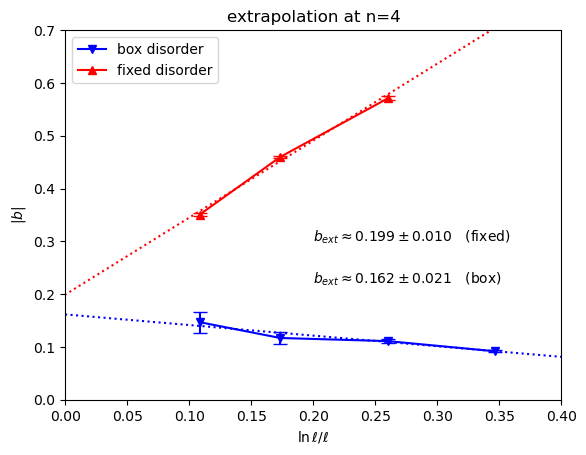

In [35]:
fig, ax = plt.subplots()
boxerr = box.b_err_vs_invl(4)
fixerr = fix.b_err_vs_invl(4)
box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
ax.plot(box.lnl_ls, box.b_vs_invl(4), '-v', color='b', label='box disorder')
ax.plot(fix.lnl_ls[1:], fix.b_vs_invl(4)[1:], '-^', color='r', label='fixed disorder')
ax.errorbar(box.lnl_ls, box.b_vs_invl(4), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(4)[1:], yerr=fixerr[1:], fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.7])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=4')

boxcoeff, boxcov = np.polyfit(box.lnl_ls, box.b_vs_invl(4), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(4)[1:], 1, cov='unscaled', w=fix_weights[1:])
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.2, 0.3, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.2, 0.22, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

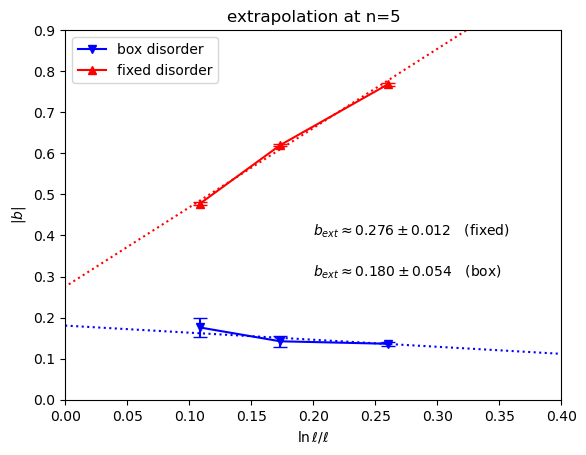

In [36]:
fig, ax = plt.subplots()
boxerr = box.b_err_vs_invl(5)
fixerr = fix.b_err_vs_invl(5)
box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
ax.plot(box.lnl_ls[1:], box.b_vs_invl(5), '-v', color='b', label='box disorder')
ax.plot(fix.lnl_ls[1:], fix.b_vs_invl(5), '-^', color='r', label='fixed disorder')
ax.errorbar(box.lnl_ls[1:], box.b_vs_invl(5), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(5), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.9])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=5')

boxcoeff, boxcov = np.polyfit(box.lnl_ls[1:], box.b_vs_invl(5), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(5), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.2, 0.4, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.2, 0.3, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/np.sqrt(3)):0,.3f}$   (box)')

plt.show()

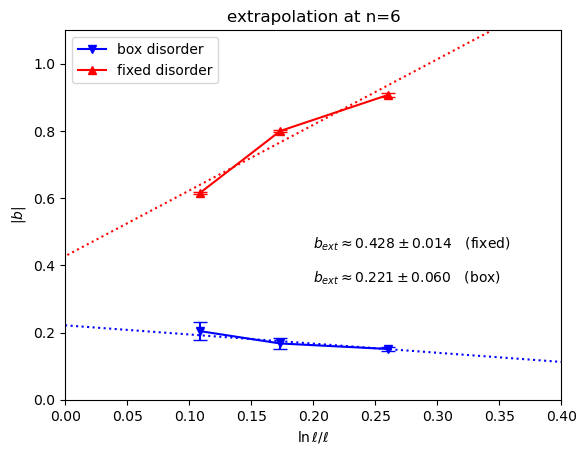

In [37]:
fig, ax = plt.subplots()
boxerr = box.b_err_vs_invl(6)
fixerr = fix.b_err_vs_invl(6)
box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
ax.plot(box.lnl_ls[1:], box.b_vs_invl(6), '-v', color='b', label='box disorder')
ax.plot(fix.lnl_ls[1:], fix.b_vs_invl(6), '-^', color='r', label='fixed disorder')
ax.errorbar(box.lnl_ls[1:], box.b_vs_invl(6), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(6), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,1.1])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=6')

boxcoeff, boxcov = np.polyfit(box.lnl_ls[1:], box.b_vs_invl(6), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(6), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.2, 0.45, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.2, 0.35, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/np.sqrt(3)):0,.3f}$   (box)')

plt.show()

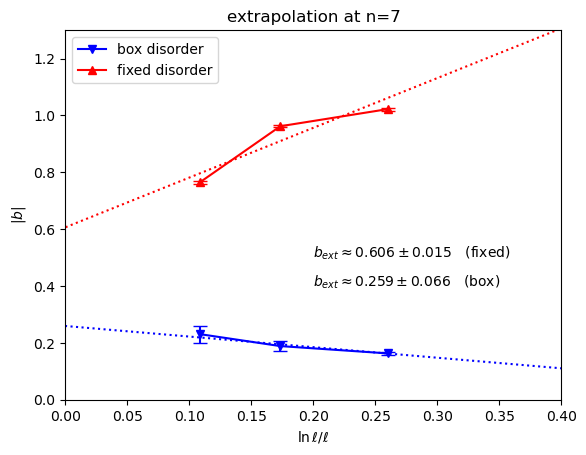

In [38]:
fig, ax = plt.subplots()
boxerr = box.b_err_vs_invl(7)
fixerr = fix.b_err_vs_invl(7)
box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
ax.plot(box.lnl_ls[1:], box.b_vs_invl(7), '-v', color='b', label='box disorder')
ax.plot(fix.lnl_ls[1:], fix.b_vs_invl(7), '-^', color='r', label='fixed disorder')
ax.errorbar(box.lnl_ls[1:], box.b_vs_invl(7), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(7), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,1.3])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=7')

boxcoeff, boxcov = np.polyfit(box.lnl_ls[1:], box.b_vs_invl(7), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(7), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.2, 0.5, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.2, 0.4, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/np.sqrt(3)):0,.3f}$   (box)')

plt.show()

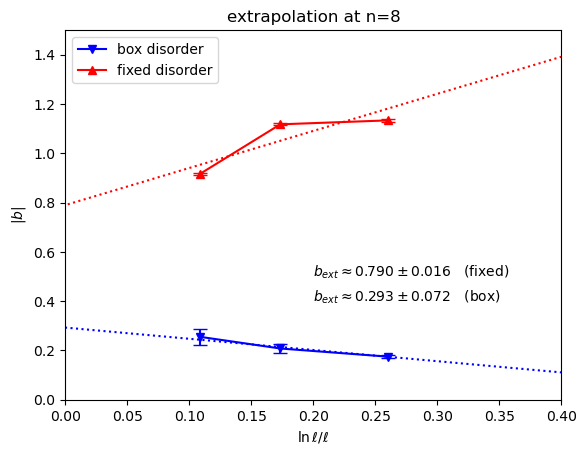

In [39]:
fig, ax = plt.subplots()
boxerr = box.b_err_vs_invl(8)
fixerr = fix.b_err_vs_invl(8)
box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
ax.plot(box.lnl_ls[1:], box.b_vs_invl(8), '-v', color='b', label='box disorder')
ax.plot(fix.lnl_ls[1:], fix.b_vs_invl(8), '-^', color='r', label='fixed disorder')
ax.errorbar(box.lnl_ls[1:], box.b_vs_invl(8), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fix.lnl_ls[1:], fix.b_vs_invl(8), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,1.5])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=8')

boxcoeff, boxcov = np.polyfit(box.lnl_ls[1:], box.b_vs_invl(8), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fix.lnl_ls[1:], fix.b_vs_invl(8), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.2, 0.5, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.2, 0.4, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/np.sqrt(3)):0,.3f}$   (box)')

plt.show()

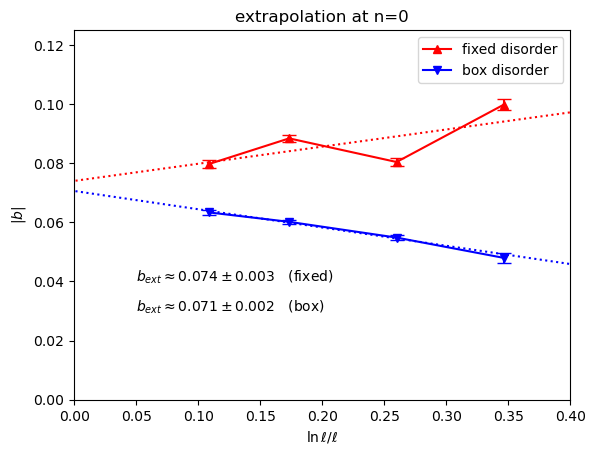

In [57]:
fig, ax = plt.subplots()
boxerr = boxmulti.b_err_vs_invl(0)
fixerr = fixmulti.b_err_vs_invl(0)
ax.plot(fixmulti.lnl_ls, fixmulti.b_vs_invl(0), '-^', color='r', label='fixed disorder')
ax.plot(boxmulti.lnl_ls, boxmulti.b_vs_invl(0), '-v', color='b', label='box disorder')
ax.errorbar(boxmulti.lnl_ls, boxmulti.b_vs_invl(0), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fixmulti.lnl_ls, fixmulti.b_vs_invl(0), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.125])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=0')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls, boxmulti.b_vs_invl(0), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls, fixmulti.b_vs_invl(0), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.04, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/2):0,.3f}$   (fixed)')
ax.text(0.05, 0.03, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

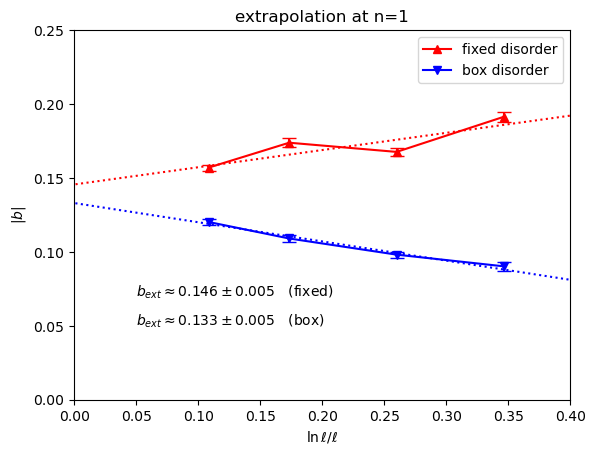

In [58]:
fig, ax = plt.subplots()
boxerr = boxmulti.b_err_vs_invl(1)
fixerr = fixmulti.b_err_vs_invl(1)
ax.plot(fixmulti.lnl_ls, fixmulti.b_vs_invl(1), '-^', color='r', label='fixed disorder')
ax.plot(boxmulti.lnl_ls, boxmulti.b_vs_invl(1), '-v', color='b', label='box disorder')
ax.errorbar(boxmulti.lnl_ls, boxmulti.b_vs_invl(1), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fixmulti.lnl_ls, fixmulti.b_vs_invl(1), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.25])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=1')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls, boxmulti.b_vs_invl(1), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls, fixmulti.b_vs_invl(1), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.07, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/2):0,.3f}$   (fixed)')
ax.text(0.05, 0.05, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

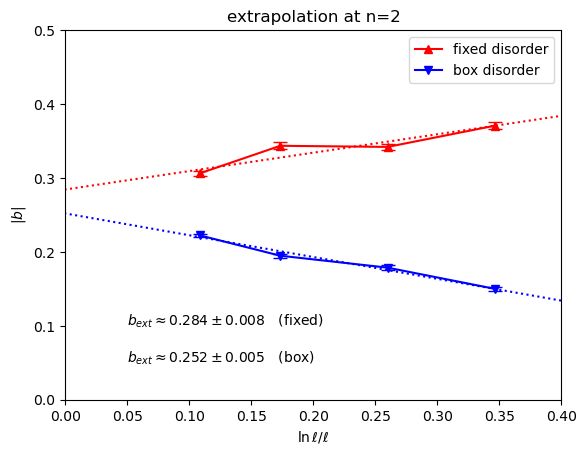

In [59]:
fig, ax = plt.subplots()
boxerr = boxmulti.b_err_vs_invl(2)
fixerr = fixmulti.b_err_vs_invl(2)
ax.plot(fixmulti.lnl_ls, fixmulti.b_vs_invl(2), '-^', color='r', label='fixed disorder')
ax.plot(boxmulti.lnl_ls, boxmulti.b_vs_invl(2), '-v', color='b', label='box disorder')
ax.errorbar(boxmulti.lnl_ls, boxmulti.b_vs_invl(2), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fixmulti.lnl_ls, fixmulti.b_vs_invl(2), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.5])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=2')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls, boxmulti.b_vs_invl(2), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls, fixmulti.b_vs_invl(2), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.1, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/2):0,.3f}$   (fixed)')
ax.text(0.05, 0.05, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

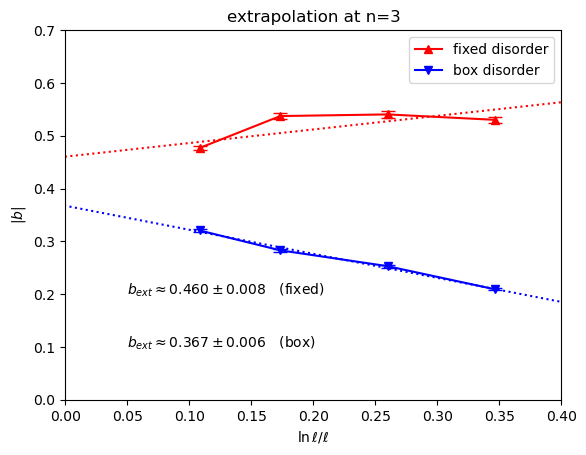

In [60]:
fig, ax = plt.subplots()
boxerr = boxmulti.b_err_vs_invl(3)
fixerr = fixmulti.b_err_vs_invl(3)
ax.plot(fixmulti.lnl_ls, fixmulti.b_vs_invl(3), '-^', color='r', label='fixed disorder')
ax.plot(boxmulti.lnl_ls, boxmulti.b_vs_invl(3), '-v', color='b', label='box disorder')
ax.errorbar(boxmulti.lnl_ls, boxmulti.b_vs_invl(3), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fixmulti.lnl_ls, fixmulti.b_vs_invl(3), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,0.7])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=3')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls, boxmulti.b_vs_invl(3), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls, fixmulti.b_vs_invl(3), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.2, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/2):0,.3f}$   (fixed)')
ax.text(0.05, 0.1, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

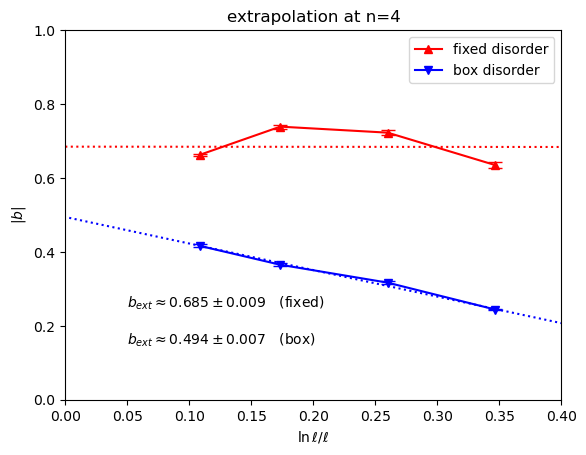

In [61]:
fig, ax = plt.subplots()
boxerr = boxmulti.b_err_vs_invl(4)
fixerr = fixmulti.b_err_vs_invl(4)
ax.plot(fixmulti.lnl_ls, fixmulti.b_vs_invl(4), '-^', color='r', label='fixed disorder')
ax.plot(boxmulti.lnl_ls, boxmulti.b_vs_invl(4), '-v', color='b', label='box disorder')
ax.errorbar(boxmulti.lnl_ls, boxmulti.b_vs_invl(4), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fixmulti.lnl_ls, fixmulti.b_vs_invl(4), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,1])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=4')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls, boxmulti.b_vs_invl(4), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls, fixmulti.b_vs_invl(4), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.25, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/2):0,.3f}$   (fixed)')
ax.text(0.05, 0.15, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/2):0,.3f}$   (box)')

plt.show()

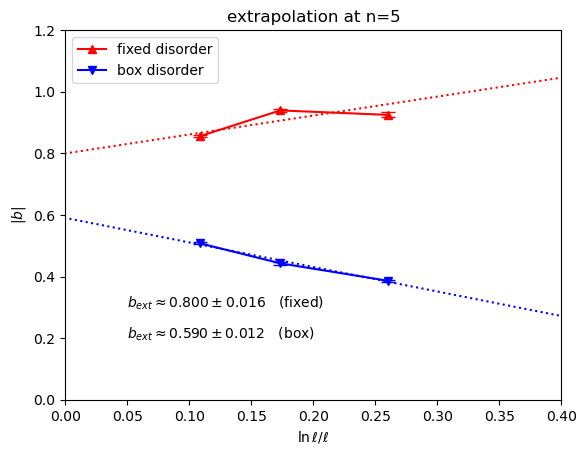

In [62]:
fig, ax = plt.subplots()
boxerr = boxmulti.b_err_vs_invl(5)
fixerr = fixmulti.b_err_vs_invl(5)
ax.plot(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(5), '-^', color='r', label='fixed disorder')
ax.plot(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(5), '-v', color='b', label='box disorder')
ax.errorbar(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(5), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(5), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,1.2])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=5')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(5), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(5), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.3, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.05, 0.2, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/np.sqrt(3)):0,.3f}$   (box)')

plt.show()

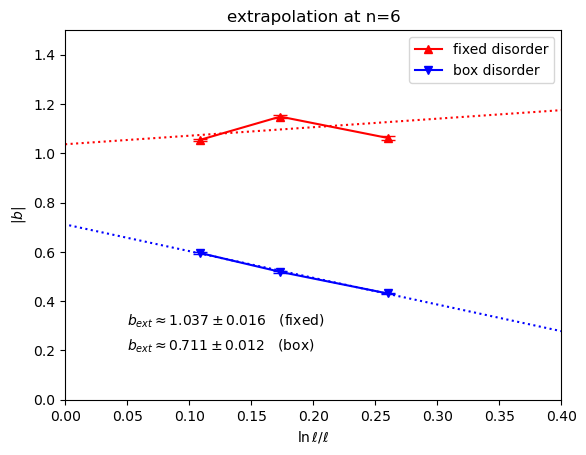

In [63]:
fig, ax = plt.subplots()
boxerr = boxmulti.b_err_vs_invl(6)
fixerr = fixmulti.b_err_vs_invl(6)
ax.plot(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(6), '-^', color='r', label='fixed disorder')
ax.plot(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(6), '-v', color='b', label='box disorder')
ax.errorbar(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(6), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(6), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,1.5])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=6')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(6), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(6), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.3, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.05, 0.2, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/np.sqrt(3)):0,.3f}$   (box)')

plt.show()

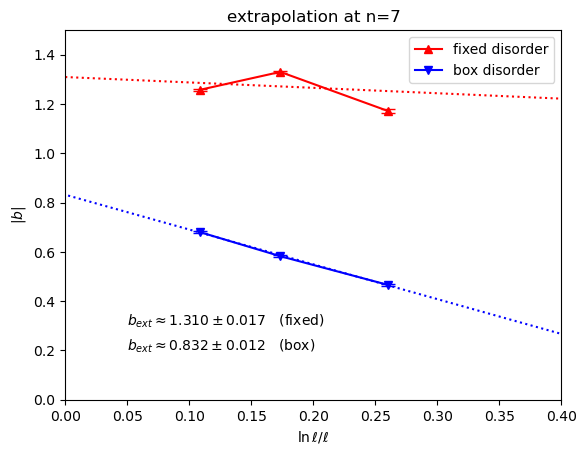

In [64]:
fig, ax = plt.subplots()
boxerr = boxmulti.b_err_vs_invl(7)
fixerr = fixmulti.b_err_vs_invl(7)
ax.plot(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(7), '-^', color='r', label='fixed disorder')
ax.plot(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(7), '-v', color='b', label='box disorder')
ax.errorbar(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(7), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(7), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,1.5])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=7')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(7), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(7), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.3, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.05, 0.2, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/np.sqrt(3)):0,.3f}$   (box)')

plt.show()

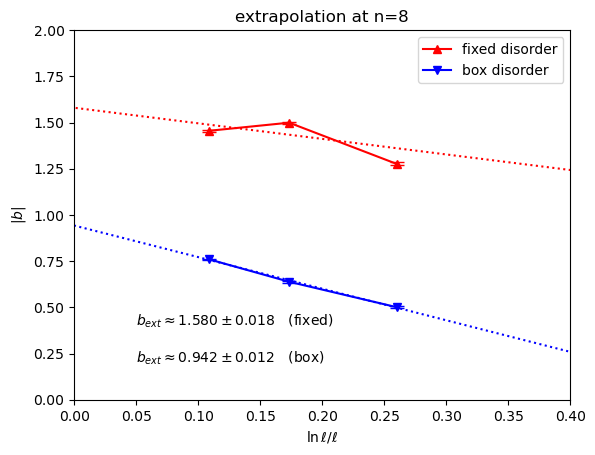

In [65]:
fig, ax = plt.subplots()
boxerr = boxmulti.b_err_vs_invl(8)
fixerr = fixmulti.b_err_vs_invl(8)
ax.plot(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(8), '-^', color='r', label='fixed disorder')
ax.plot(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(8), '-v', color='b', label='box disorder')
ax.errorbar(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(8), yerr=boxerr, fmt='none', ecolor='b', capsize=5.0)
ax.errorbar(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(8), yerr=fixerr, fmt='none', ecolor='r', capsize=5.0)
ax.set_xlabel(f"$\ln \ell/\ell$")
ax.set_ylabel(f"$|b|$")
ax.set_ylim([0,2])
ax.set_xlim([0,0.4])
ax.legend()
ax.set_title(f'extrapolation at n=8')

box_weights = [ 1/(err*np.sqrt(10)) for err in boxerr]
fix_weights = [ 1/(err*np.sqrt(10)) for err in fixerr]
boxcoeff, boxcov = np.polyfit(boxmulti.lnl_ls[1:], boxmulti.b_vs_invl(8), 1, cov='unscaled', w=box_weights)
fixcoeff, fixcov = np.polyfit(fixmulti.lnl_ls[1:], fixmulti.b_vs_invl(8), 1, cov='unscaled', w=fix_weights)
box_slope, box_int = boxcoeff
fix_slope, fix_int = fixcoeff
boxint_err = np.sqrt(boxcov[1,1])
fixint_err = np.sqrt(fixcov[1,1])
x = np.linspace(-0.1, 0.5)
ax.plot(x, box_int + box_slope*x, 'b:')
ax.plot(x, fix_int + fix_slope*x, 'r:')
ax.text(0.05, 0.4, rf'$b_{{ext}} \approx {(fix_int):0,.3f} \pm {(fixint_err/np.sqrt(3)):0,.3f}$   (fixed)')
ax.text(0.05, 0.2, rf'$b_{{ext}} \approx {(box_int):0,.3f} \pm {(boxint_err/np.sqrt(3)):0,.3f}$   (box)')

plt.show()